# Yeast cells detection sample notebook

This pipeline detects, segments, and tracks yeast cells in time-series microscopy data. It uses a mask R-CNN model trained on synthetic brightfield budding yeast cell data to detect and segment the cells. For tracking, the clustering algorithm DBSCAN is used with input distances based on the intersection-over-union metric. The cell (tracking) label, its centroid position, and area in pixels are extracted.

In [1]:
#@markdown # Configuration, dependencies and imports
import os

# To avoid that tensorflow claims all GPU RAM and causes torch to OOM
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import sys
import warnings
from importlib import reload

mask_rcnn_model_version = "v1"

from google import colab

data_path = '/content/data/'
model_path = '/content/models/'
for path in [data_path, model_path]:
  os.makedirs(path, exist_ok=True)

def install_mask_rcnn():
  import setuptools
  !pip3 install --upgrade setuptools
  reload(setuptools)
  import setuptools
  !pip3 install git+https://github.com/ymzayek/yeastcells-detection-maskrcnn.git

try: from yeastcells import segmentation, tracking, visualize, features, evaluation, yit, data
except ImportError:
  install_mask_rcnn()
  from yeastcells import segmentation, tracking, visualize, features, evaluation, yit, data

try: from download import download
except ImportError:
  !pip3 install download
  from download import download

from pkg_resources import parse_version
try:
  import gdown
  if parse_version(gdown.__version__) < parse_version('3.13.0'):
    !pip3 uninstall -y gdown
    reload(gdown)
    import gdown
except:
  !pip3 install -U git+https://github.com/wkentaro/gdown.git
  reload(gdown)
  import gdown
else:
  import gdown

try: import umsgpack
except ImportError:
  !pip3 install umsgpack
  import umsgpack

for module in [evaluation, yit, data,
               segmentation, tracking, 
               visualize, features,
]:
  reload(module)

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile
from tqdm.auto import tqdm
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.exposure import equalize_adapthist
import matplotlib.animation as animation 
%matplotlib inline

#check for hosted runtime
from tensorflow.python.client.device_lib import list_local_devices
print(f"Found {sum(x.device_type == 'GPU' for x in list_local_devices())} GPU(s)")

Found 1 GPU(s)


In [4]:
#@markdown # Download benchmark data and model

#data
gdown.cached_download(
    'https://drive.google.com/uc?id=1BFmLfWsFe7tuaCw32V-EQyKwMM9tBXU4',
    f'{data_path}/YIT-Benchmark2.zip',
    quiet=True)
!unzip -q '{data_path}/YIT-Benchmark2.zip' -d '{data_path}/YIT-Benchmark2/'
!find '{data_path}/YIT-Benchmark2' -type f -name "RawDataTS.zip" -delete

#models
gdown.cached_download(
    'https://drive.google.com/uc?id=1oa1mC6SpwzY5guKXqTClu1YDvHL-tzRh',
    f'{model_path}/maskrcnn/{mask_rcnn_model_version}/model_final.pth',
    md5='736840ffbb94127712eda5fadaccef64',
    quiet=True)

None

mask_rcnn_model = f'{model_path}/maskrcnn/{mask_rcnn_model_version}/model_final.pth'

## Read movie

Our model requires imported microscopy movies as arrays of dimensions  $frames \times height \times width \times 3$ with `uint8` values in `(0, 256)`. The movie should contain no other channels than brightfield, and the brightfield channel should have reasonable contrast. The last dimension of the input array should contain three times the same (grayscale) brightfield image, due to the input requirements of detectron2. If an input movie has a different arrangement of channels/dimensions, a preprocessing step will be necessary to bring it to the required form. The example code below preprocesses the YIT datasets, which have dimensions $frames \times height \times width$, to the correct input format.



In [3]:
testset = 'TestSet1'
images = yit.get_test_movie(data_path, testset)
images.shape # (frames, length, width, channels)

(60, 512, 512, 3)

## Apply Mask-RCNN model

The Mask-RCNN model segments yeast cells in each frame independently. The output is a structure where every cell is represented as an instance of bounding boxes, masks and probability scores.

For example, one can access the 13th bounding box in the 7th time frame like this.

    x0, y0, x1, y1 = np.array(output[6]['instances'].pred_boxes.tensor.to('cpu')[12])

In [4]:
detections, masks = segmentation.get_segmentation(
    images, mask_rcnn_model, seg_thresh=0.8, device='cuda:0')
detections['area'] = masks.sum(1).sum(1)
above_threshold = detections['area'] >= 50
detections = detections[above_threshold].copy()

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:115

## Tracking detections across time frames

`tracked_cells` marks the centroids of each detection in a dataframe with columns `frame`, `x` and `y`, and a column `cell` to track the cells. Negative values (-1) mark outliers that were not tracked.

These tracks are plot in 3D.

In [5]:
detections = tracking.track_cells(
    detections, masks, dmax=1, min_samples=3, eps=0.6, device='cuda:0')

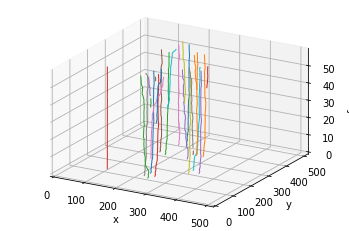

In [6]:
# plot yeast cell positions over time

ax = visualize.plot_paths(detections, style={'linewidth': 1}, xlim=(0, 512), ylim=(0, 512), title='',)

## Visualize as a movie

Creates a colorfull stack of images, each cell is drawn as a polygon in the same color across frames, and can be labeled. Set `frame_style` to None to remove the frame numbers and `label_style` to None to remove cell labels. 

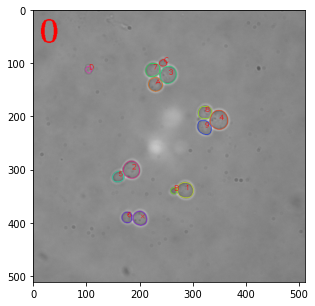

In [7]:
scene = visualize.create_scene(images, detections, masks,
                               frame_style={}, label_style={})

# When interactive plotting is available, this can be animated. Otherwise
# a still image of the first frame is shown.

movie = visualize.show_animation(scene, title='', delay=700) 

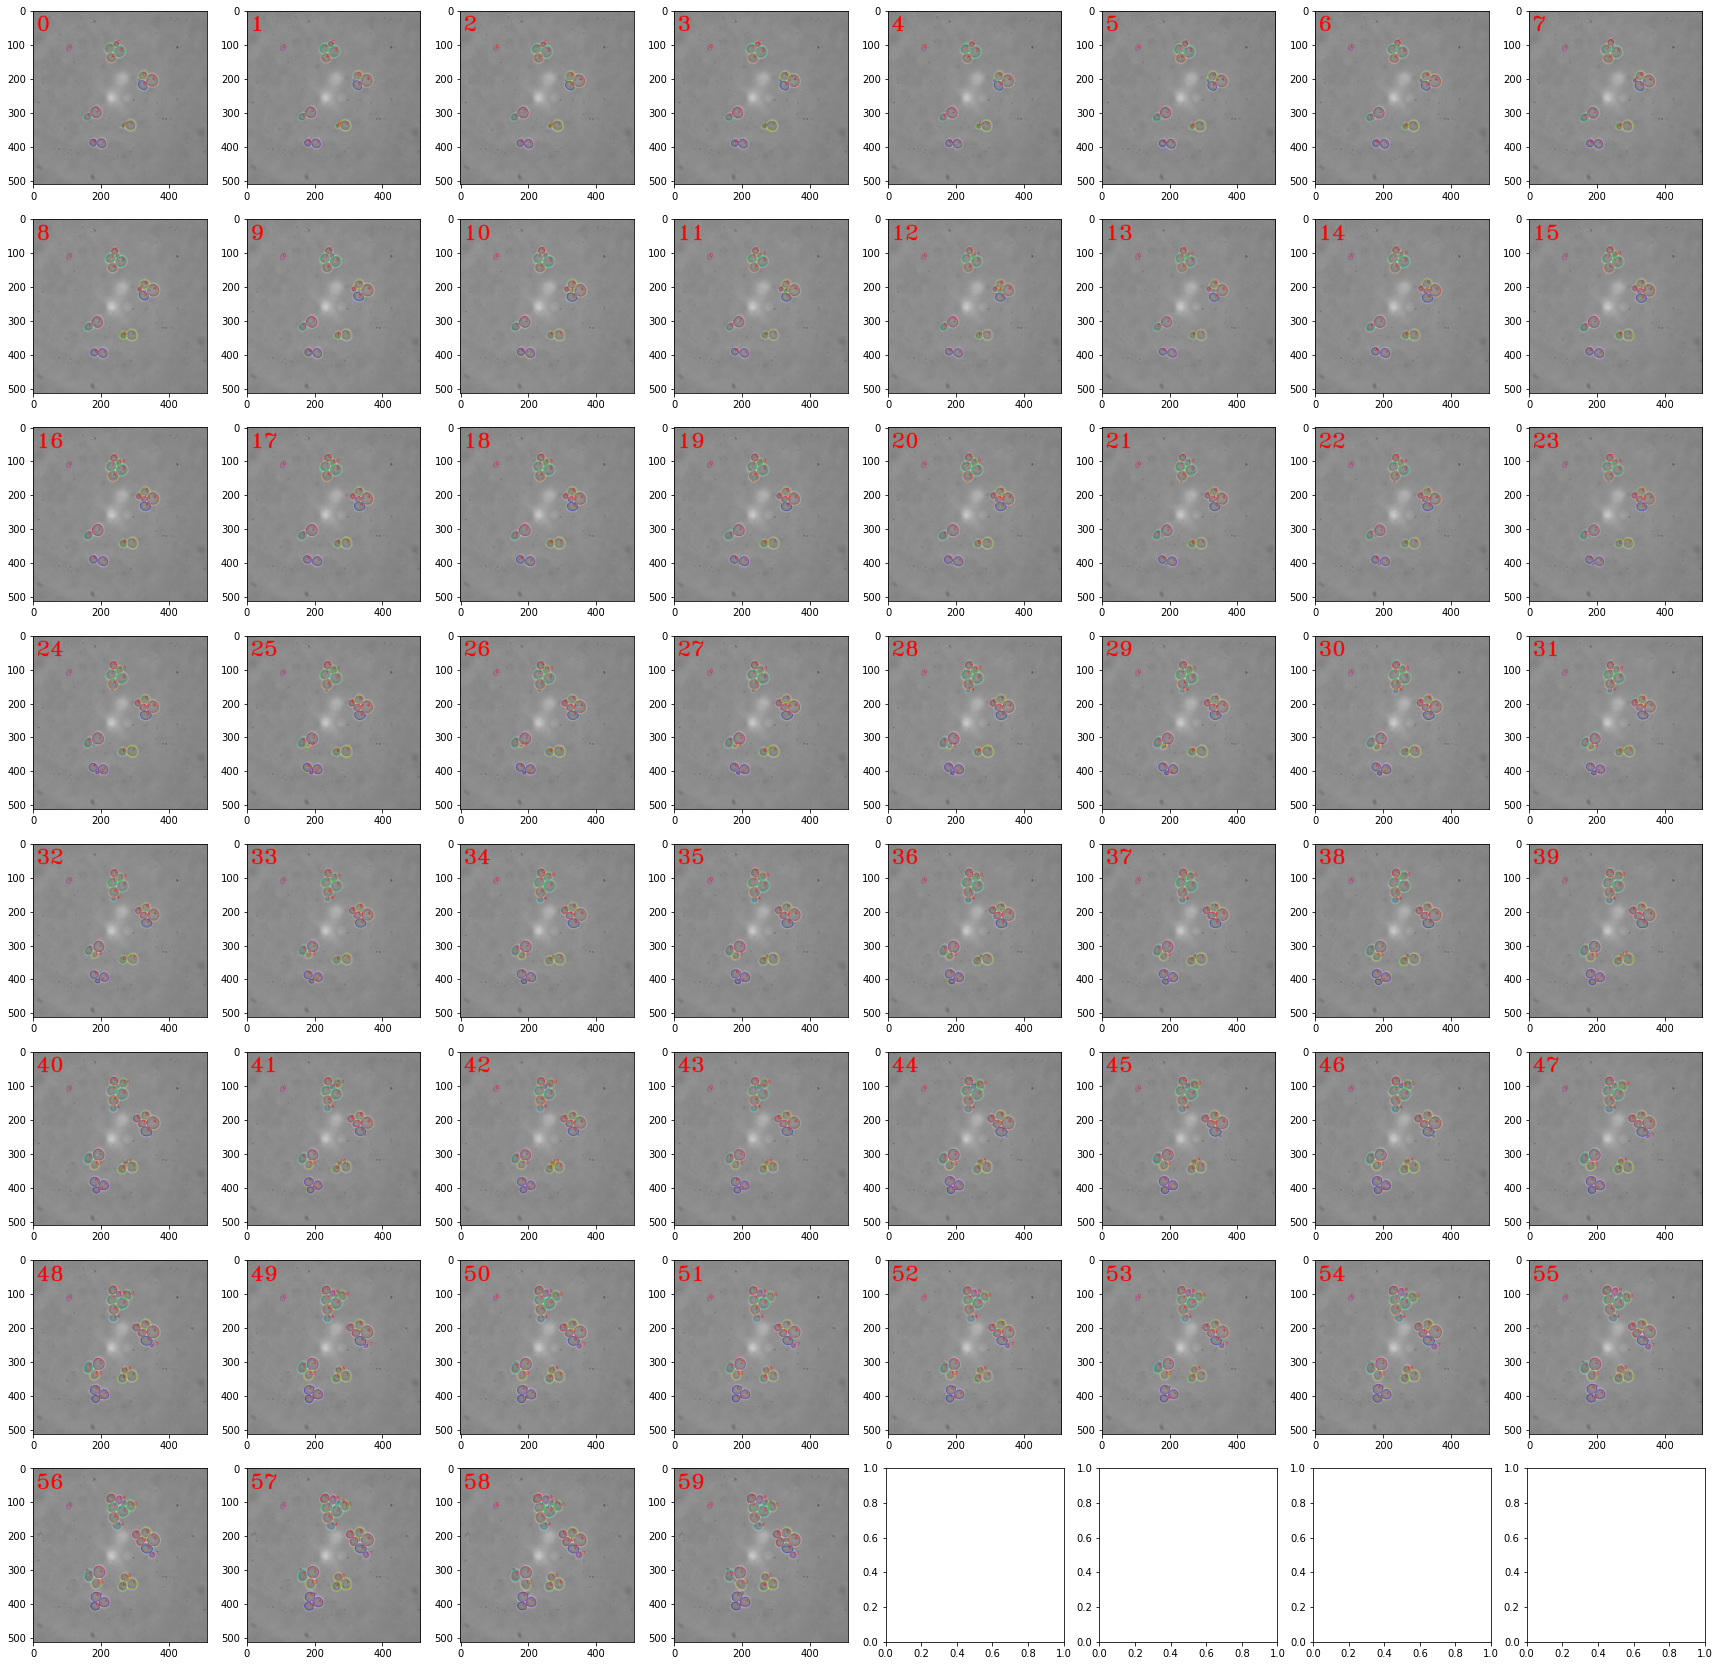

In [8]:
# Alternatively, plot every frame independently
axes = plt.subplots(8, 8, figsize=(30, 30))[1].ravel()
for axis, frame in zip(axes, scene):
  axis.imshow(frame)

In [ ]:
#@markdown Download above visualization as gif
download_animation = False #@param {"type": "boolean"}

#save movie as gif
if download_animation:
  writergif = animation.PillowWriter(fps=10) 
  movie.save('animation.gif', writer=writergif)

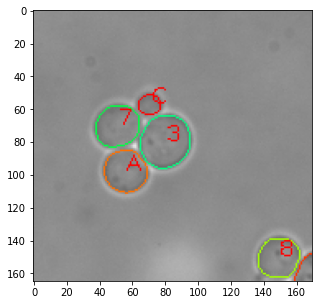

In [9]:
# One may extract the one particular cell, e.g. 3, in time and spatial dimensions
cell_scene = visualize.select_cell(scene, detections, 3, w=80)

movie = visualize.show_animation(cell_scene, title='', delay=500)

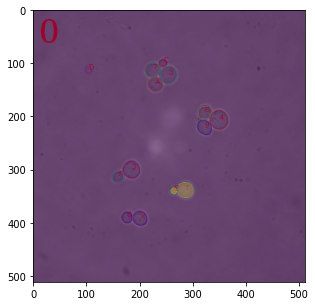

In [10]:
#example mask overlay
plt.figure(figsize=(5,5))
labels = [1,11]
plt.imshow(scene[0])
for label in labels:
    mask = [masks[i] for i in np.where(detections['cell'].values==label)[0]]
    ax = plt.imshow(mask[0], alpha=0.3)

## Output as a DataFrame (or spreadsheet)

This creates a dataframe with columns for time, frame number, cell number, position and the cell area. Of course, other features could be added when needed.

This dataframe can be exported to excel or csv spreadsheets.

In [12]:
detections['area'] = features.get_areas(masks[np.array(detections.index)])
detections['pixel intensity'] = features.get_pixel_value_sum(images[..., 0], detections, masks[np.array(detections.index)])
detections['mean pixel intensity'] = detections['pixel intensity'] / detections['area']
detections.head(10)

,frame,cell,mask,x,y,segmentation_score,area,pixel intensity,mean pixel intensity
0,0,1,0,286.467940,338.562074,0.999735,733,93063,126.961801
1,0,0,1,200.943103,391.627586,0.999722,580,74743,128.867241
2,0,2,2,185.084146,300.136585,0.999655,820,107394,130.968293
3,0,3,3,254.153186,121.666667,0.999315,816,107686,131.968137
4,0,6,4,176.486322,390.000000,0.999049,329,41192,125.203647
5,0,4,5,349.693878,206.497959,0.998900,980,131547,134.231633
6,0,5,6,159.961538,313.373626,0.998384,364,44857,123.233516
7,0,10,7,229.974955,139.740608,0.997817,559,73504,131.491950
8,0,7,8,225.050967,112.304042,0.997752,569,75440,132.583480
9,0,8,9,323.306796,192.491262,0.997679,515,68166,132.361165


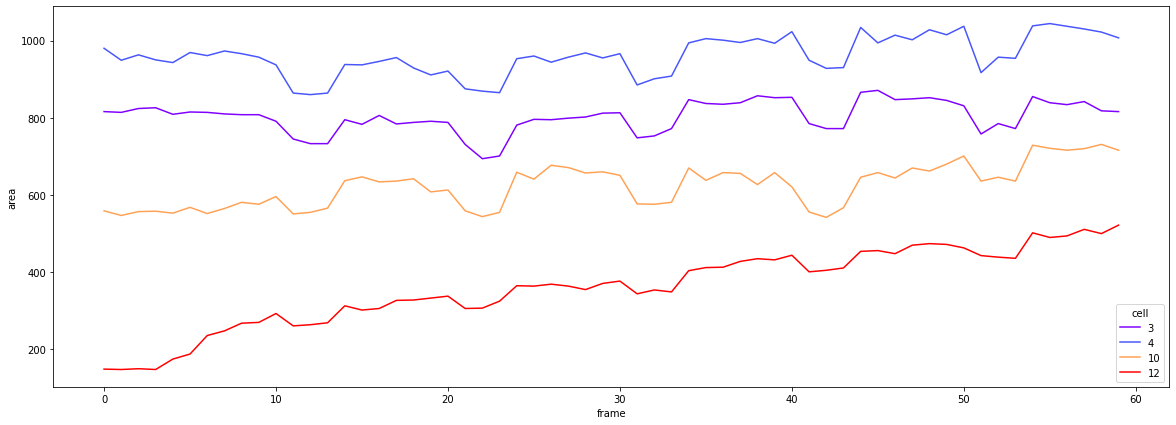

In [13]:
plt.figure(figsize=(20, 7))
sns.lineplot(
  data = detections[detections['cell'].isin([3, 4, 12, 10])],
  x='frame', hue='cell', palette='rainbow',
  y='area',
  # y='pixel intensity',
  # y='mean pixel intensity',
)

In [ ]:
try:
  from google.colab import files
  detections.to_excel('cell detections.xlsx')
  files.download('cell detections.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Detection statistics

`pandas` allows finding cell statistics, for example

    # Number of tracked frames for each cell:
    detections['cell'].value_counts()

    # Number of detections:
    len(detections)

    # Detections per frame
    detections['frame'].value_counts()

Note that cells labeled with a -1 were unable to be tracked

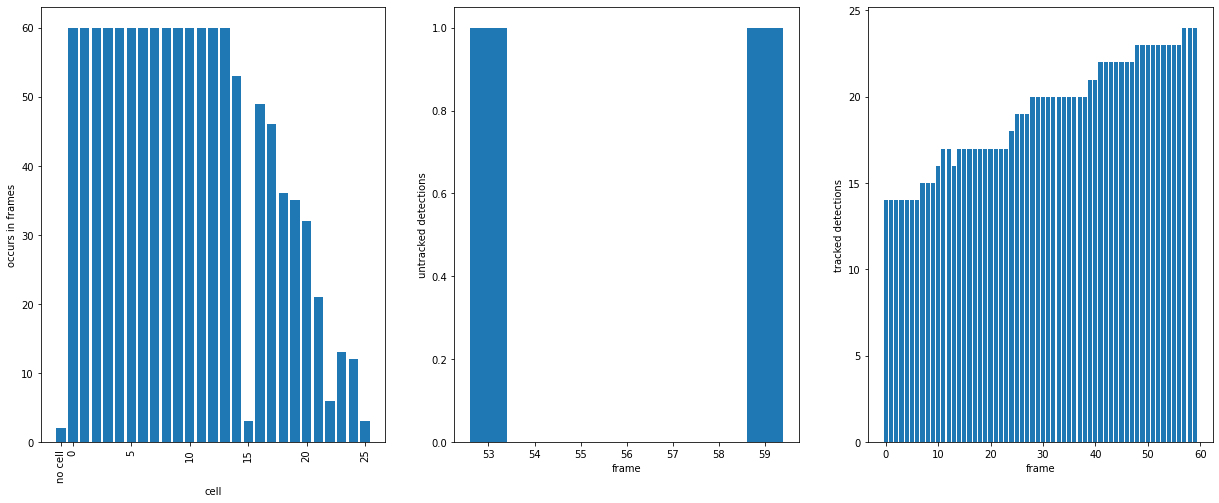

In [14]:
_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(21, 8))

detections_per_cells = detections['cell'].value_counts()
ax0.bar(detections_per_cells.index, detections_per_cells.values)
ax0.set_xlabel('cell'); ax0.set_ylabel('occurs in frames')
ax0.set_xticks([-1, 0, 5, 10, 15, 20, 25])
ax0.set_xticklabels(['no cell', 0, 5, 10, 15, 20, 25],  rotation=90)


detections_per_frame = detections[detections['cell'] == -1]['frame'].value_counts()
ax1.bar(detections_per_frame.index, detections_per_frame.values)
ax1.set_xlabel('frame'); ax1.set_ylabel('untracked detections')

detections_per_frame = detections[detections['cell'] >= 0]['frame'].value_counts()
ax2.bar(detections_per_frame.index, detections_per_frame.values)
ax2.set_xlabel('frame'); ax2.set_ylabel('tracked detections')
None

## Export masks as tiff stack file


In [ ]:
masks_out = 'masks.tif'
with tifffile.TiffWriter(masks_out) as stack:
  for m in masks:
      stack.save(m)

try:
  from google.colab import files
  files.download('masks.tif')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Export example segmentation results

In [ ]:
#@markdown Export segmentation results
export_example_results = False #@param {"type": "boolean"}

if export_example_results:
  from skimage.transform import resize
  from skimage.io import imsave, imread
  import cv2

  crops = {
      'Pic2_microfluidic.png': (slice(320, 450), slice(150, 310)),
      'Pic5_agarpad_extra.png': (slice(230, 420), slice(310, 509)),
  }

  for image_filename in [
    'Pic1_agarpad_crowded.png',
    'Pic1_agarpad_intermediate.png',
    'Pic1_agarpad_sparse.png',
    'Pic2_microfluidic.png',
    'Pic3_microfluidic.png',
    'Pic4_agarpad_mutant.png',
    'Pic5_agarpad_extra.png',]:
    download(f'https://raw.githubusercontent.com/ymzayek/'
            f'yeastcells-detection-maskrcnn/main/figures/'
            f'segmentations/{image_filename}',
            image_filename)
    image = imread(image_filename)[None]
    
    detections, masks = segmentation.get_segmentation(
        image, mask_rcnn_model, seg_thresh=0.8, device='cuda:0')
    detections['area'] = masks.sum(1).sum(1)
    above_threshold = detections['area'] >= 50
    detections = detections[above_threshold].copy()
    detections['cell'] = 0
    scene_thick = visualize.create_scene(image, detections, masks,
                                        frame_style=None, label_style=None,
                                        cell_style={'color': [255, 0, 255],
                                                    'thickness': 2})
    scene_thin = visualize.create_scene(image, detections, masks,
                                        frame_style=None, label_style=None,
                                        cell_style={'color': [255, 0, 255],
                                                    'thickness': 1})
    
    with_overlays = (4.*scene_thick + image)[0] / 5 / 255
    if image_filename in crops:
      y, x = crops[image_filename]
      cv2.rectangle(
          with_overlays,
          (x.start, y.start),
          (x.stop, y.stop),
          (1, 0, 0), 5)
    results = {'original': image[0],
              'contours': (255 * with_overlays).astype(np.uint8)}
    if image_filename in crops:
      with_overlays = ((4.*scene_thin + image)[0] / 5 / 255)[crops[image_filename]]
      results['cutout'] = (255 * with_overlays).astype(np.uint8)
    for name, image in results.items():
      fn = f'{image_filename[:-4]}_{name}.png'
      imsave(fn, image)
      !zip -qq example-segmentations.zip '{fn}'
      !rm '{fn}'
  
  from google.colab import files

  files.download('example-segmentations.zip')